# Electricity Price Forecasting

Data Source: https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather

Predicting electricity prices is valuable to a range of market participants including generators, consumers, and system operators. This paper investigates the use of neural networks to forecast hour-ahead Spanish prices based on data between 2015 and 2018 using a range of generation, consumption, and weather features. Three network types were evaluated: 'vanilla' Recurrent Neural Networks (RNN), Gated Recurrent Units (GRU), and Long Short-Term Memory networks (LSTM). Three different network depths were compared for the GRU network: 1 layer, 2 layer, and 3 layer RNNs. Within the computational limitations of this project, the 2 layer GRU network performed best, with an R squared of 0.78.

***
## Setup

### Import libraries

In [1]:
# Standard Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# For Pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import r2_score

In [3]:
# For Modelling
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from tensorflow.keras.callbacks import History
from tensorflow.keras import optimizers
import tensorflow as tf

### Setup Filepaths

In [4]:
filepath_energy = 'data&code/energy_dataset.csv'
filepath_weather = 'data&code/weather_features.csv'

***
## Data Exploration, Cleansing & Preparation

### Load Files

In [5]:
df_raw_energy = pd.read_csv(filepath_energy)
df_raw_weather = pd.read_csv(filepath_weather)

# Convert dates to datetime format
df_raw_energy['time'] = pd.to_datetime(df_raw_energy['time'], utc=True, infer_datetime_format=True)
df_raw_weather['time'] = pd.to_datetime(df_raw_weather['dt_iso'], utc=True, infer_datetime_format=True)

### Explore Weather Dataset

In [6]:
display(df_raw_weather.head(1))
display(df_raw_weather.info())

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,time
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n,2014-12-31 23:00:00+00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   dt_iso               178396 non-null  object             
 1   city_name            178396 non-null  object             
 2   temp                 178396 non-null  float64            
 3   temp_min             178396 non-null  float64            
 4   temp_max             178396 non-null  float64            
 5   pressure             178396 non-null  int64              
 6   humidity             178396 non-null  int64              
 7   wind_speed           178396 non-null  int64              
 8   wind_deg             178396 non-null  int64              
 9   rain_1h              178396 non-null  float64            
 10  rain_3h              178396 non-null  float64            
 11  snow_3h              178396 non-null  float64            
 12  cl

None

In [7]:
# Check the data for nulls, duplicates, and zeroes
print("Weather Data time range:",df_raw_weather.dt_iso.min(),df_raw_weather.dt_iso.max())
print("Any NULLs in dataset:",df_raw_weather.isnull().any().any())
print("Count of duplicate rows in dataset:",df_raw_weather.duplicated().sum())
print("Rows for each city:")
print(df_raw_weather.city_name.value_counts())
df_raw_weather_info=pd.DataFrame()
df_raw_weather_info["missing_no"] = df_raw_weather.isnull().sum()
df_raw_weather_info["missing_rate"] = round(df_raw_weather.isnull().sum()/len(df_raw_weather),3)
df_raw_weather_info["zero_no"] = df_raw_weather.eq(0).sum()
df_raw_weather_info["zero_rate"] = round(df_raw_weather.eq(0).sum()/len(df_raw_weather),3)
df_raw_weather_info["unique_no"] = df_raw_weather.nunique()
display(df_raw_weather_info)

Weather Data time range: 2015-01-01 00:00:00+01:00 2018-12-31 23:00:00+01:00
Any NULLs in dataset: False
Count of duplicate rows in dataset: 21
Rows for each city:
Madrid        36267
Bilbao        35951
Seville       35557
 Barcelona    35476
Valencia      35145
Name: city_name, dtype: int64


,missing_no,missing_rate,zero_no,zero_rate,unique_no
dt_iso,0,0.0,0,0.000,35064
city_name,0,0.0,0,0.000,5
temp,0,0.0,0,0.000,20743
temp_min,0,0.0,0,0.000,18553
temp_max,0,0.0,0,0.000,18591
pressure,0,0.0,2,0.000,190
humidity,0,0.0,63,0.000,100
wind_speed,0,0.0,18490,0.104,36
wind_deg,0,0.0,24920,0.140,361
rain_1h,0,0.0,159008,0.891,7


There are no Nulls in the dataset, but there are some duplicate rows that will need removing. Some columns have a significant number of zero values, which are not likely to be useful for prediction and so should be removed. There are no columns with only one repeating value.

In [8]:
print("The range of values for 'weather_description' are:", df_raw_weather['weather_description'].unique())
print("The range of values for 'weather_main' are:", df_raw_weather['weather_main'].unique())
print("The range of values for 'weather_icon' are:", df_raw_weather['weather_icon'].unique())

The range of values for 'weather_description' are: ['sky is clear' 'few clouds' 'scattered clouds' 'broken clouds'
 'overcast clouds' 'light rain' 'moderate rain' 'heavy intensity rain'
 'mist' 'heavy intensity shower rain' 'shower rain' 'very heavy rain'
 'thunderstorm with heavy rain' 'thunderstorm with light rain'
 'thunderstorm with rain' 'proximity thunderstorm' 'thunderstorm'
 'light intensity shower rain' 'light intensity drizzle' 'fog' 'drizzle'
 'smoke' 'heavy intensity drizzle' 'haze' 'proximity shower rain'
 'light intensity drizzle rain' 'light snow' 'rain and snow'
 'light rain and snow' 'snow' 'light thunderstorm' 'heavy snow' 'sleet'
 'rain and drizzle' 'shower sleet' 'light shower sleet'
 'light shower snow' 'proximity moderate rain' 'ragged shower rain'
 'sand dust whirls' 'proximity drizzle' 'dust' 'squalls']
The range of values for 'weather_main' are: ['clear' 'clouds' 'rain' 'mist' 'thunderstorm' 'drizzle' 'fog' 'smoke'
 'haze' 'snow' 'dust' 'squall']
The range of v

The categorical variables are unlikely to provide predictive power beyond that provided already by the numerical variables as they seem to be both qualitative and summaries of information already provided in the cloud and rain variables.

In [9]:
display(df_raw_weather.describe())

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


From the initial summary statistics I am concerned about outliers in pressure (maximum and minimum do not look sensible) and wind_speed (maximum looks too high). It should be noted that temperatures are in Kelvin so are reasonable.

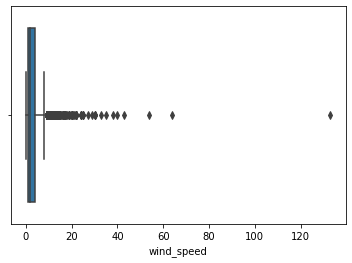

In [10]:
sns.boxplot(x=df_raw_weather['wind_speed'])
plt.show()

Record wind speeds for extreme storms in Europe can go as high as 70m/s, so we can discuss as an outlier the value over 120m/s shown above. The values below 70m/s are possible and so will be retained (although looking at if there are any extreme storms in this time period could identify further outliers if time allowed).

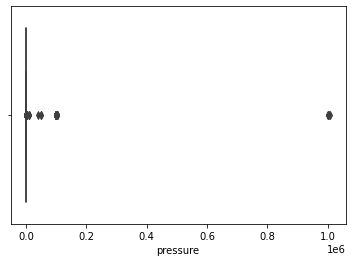

In [11]:
sns.boxplot(x=df_raw_weather['pressure'])
plt.show()

For Europe, historical maximum air pressures lie around 1060hPa and record minimums at 920hPa. For the plot about we can see that it is not just the maximum values that are an issue. Therefore I will interpolate for any values outside the range of 920-1060hPa.

### Prepare Weather Dataset

In [6]:
# Drop columns containing excessive (>90%) zeroes (and duplicate time column)
df_weather=df_raw_weather.drop(['dt_iso','rain_3h', 'snow_3h'], axis=1, inplace=False)

# Drop columns containing qualitative categorical data
df_weather=df_weather.drop(['weather_id','weather_main','weather_description','weather_icon'], axis=1, inplace=False)

In [7]:
# Drop duplicates
df_weather=df_weather.drop_duplicates()
df_weather = df_weather.drop_duplicates(subset=['time', 'city_name'],keep='first')
print("Rows for each city:")
print(df_weather.city_name.value_counts())

Rows for each city:
Valencia      35064
 Barcelona    35064
Bilbao        35064
Madrid        35064
Seville       35064
Name: city_name, dtype: int64


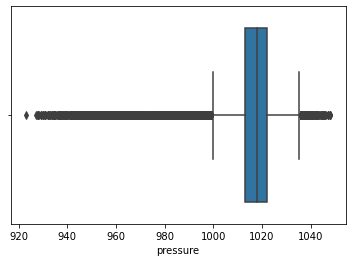

In [8]:
# Interpolate Outliers
df_weather.loc[df_weather['pressure'] > 1060, 'pressure'] = np.nan
df_weather.loc[df_weather['pressure'] < 920, 'pressure'] = np.nan
df_weather.loc[df_weather['wind_speed'] > 70, 'wind_speed'] = np.nan
df_weather.interpolate(method='ffill', inplace=True, axis=0)

# Replot pressure without outliers
sns.boxplot(x=df_weather['pressure'])
plt.show()

### Weather Dataset Feature Engineering

In [9]:
# Split into one dataframe for each city and then merge together
city_names_list = df_weather['city_name'].unique()
count = 0
for name in city_names_list:
    print(name)
    count += 1       
    df_temp = df_weather[df_weather['city_name'] == name].set_index('time')
    name_str = str(name).replace(" ", "")
    df_temp = df_temp.drop(['city_name'], axis=1, inplace=False)
    df_temp = df_temp.add_suffix("_"+name_str)
    if count == 1:
        df_weather_split = df_temp
    else:
        df_weather_split = pd.merge(df_weather_split, df_temp, how = 'outer', on='time')
display(df_weather_split.head(1))

Valencia
Madrid
Bilbao
 Barcelona
Seville


,temp_Valencia,temp_min_Valencia,temp_max_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,clouds_all_Valencia,temp_Madrid,...,clouds_all_Barcelona,temp_Seville,temp_min_Seville,temp_max_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,270.475,270.475,270.475,1001.0,77,1.0,62,0.0,0,267.325,...,0,273.375,273.375,273.375,1039.0,75,1.0,21,0.0,0


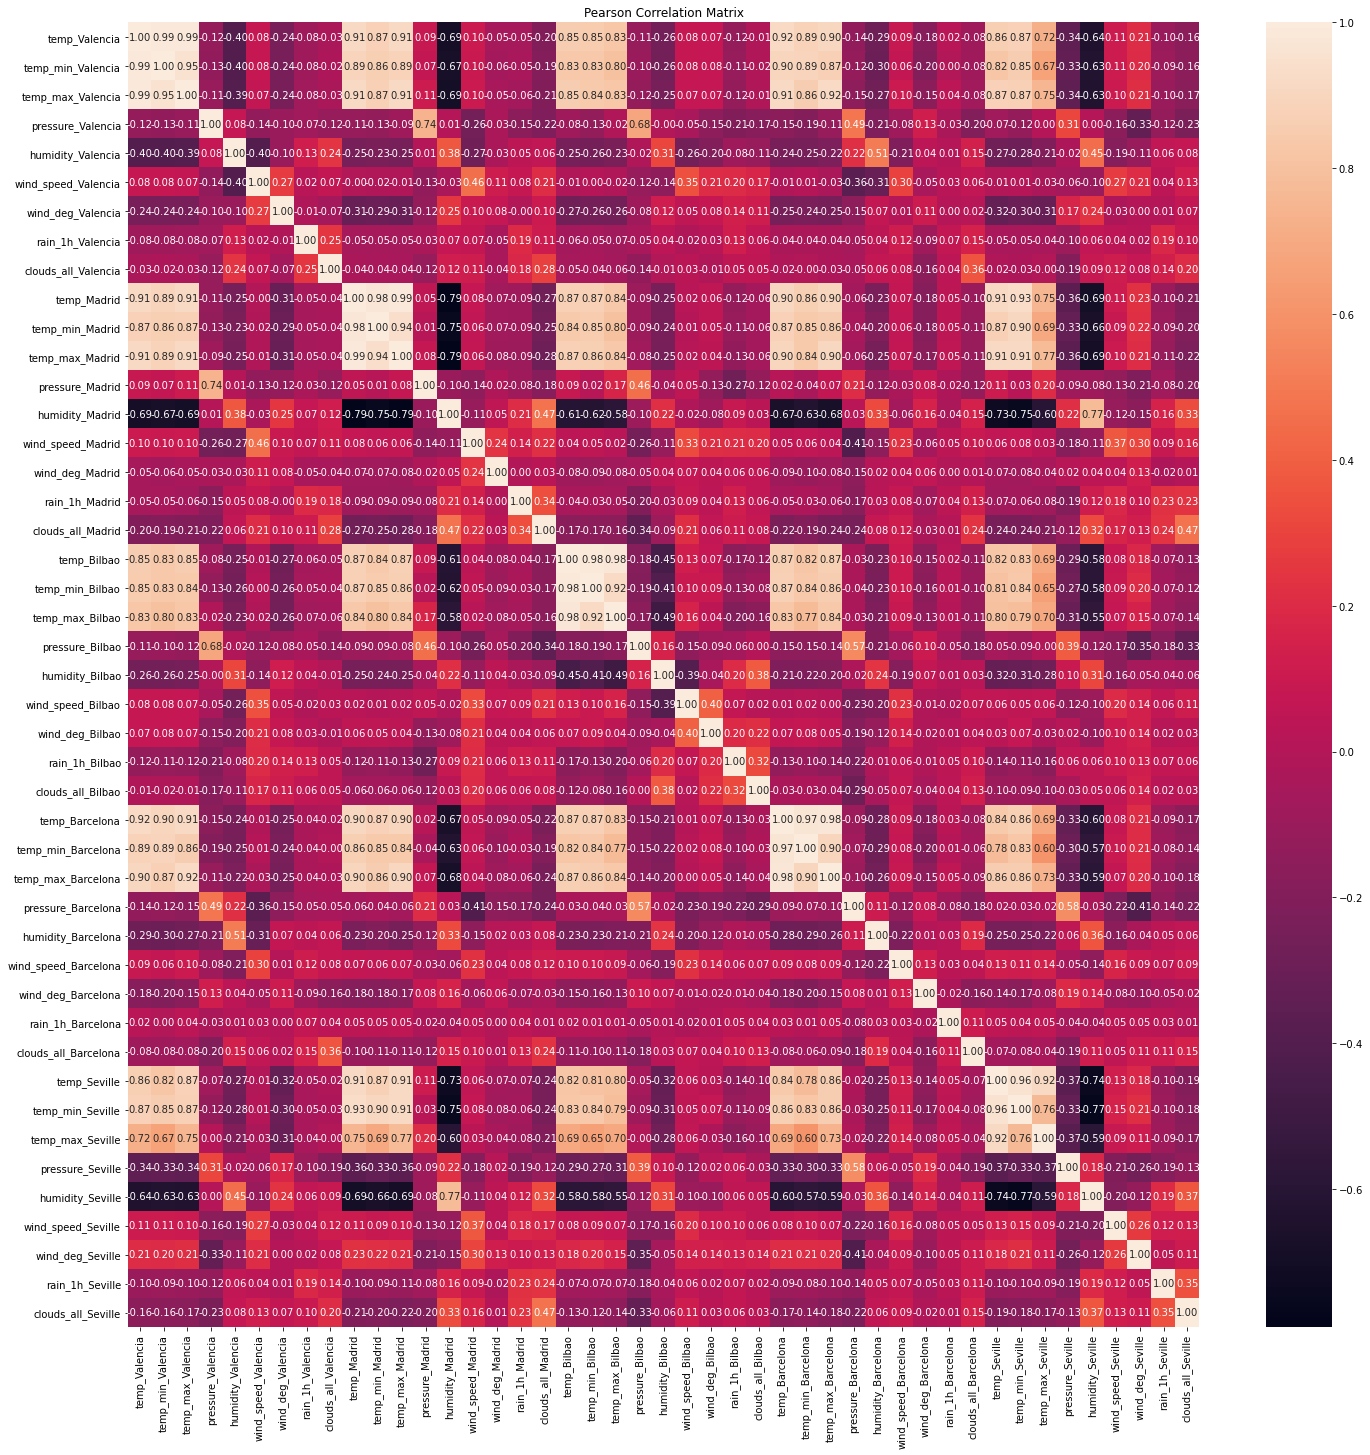

In [16]:
# Display Correlations amoung weather variables
correlations = df_weather_split.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

Looking at the correlations, it stands out that for the same city the correlations between the different temperature variables (temp, temp_max, and temp_min) are generally very high (always over 0.7, but usually over 0.95). Therefore, I will drop the min and max variables. Also, between different cities there are high correlations for the temperature variables, and so it makes sense to use an average temperature across all cities rather than each as their own variable.
<br><br>
Some of the humidity correlations (particularly between humidity and temperatures) are also high in magnitude, but this is only the case for Seville and Madrid and even then the values are typically between 0.5 and 0.7 so there might be more information in these variables than just in temperature so it is not as clear that they should be removed or combined.

In [10]:
# Create a new mean temp column and then drop all other temp columns
df_weather_split['mean_temp'] = df_weather_split[['temp_Valencia',
                                                     'temp_Madrid',
                                                     'temp_Bilbao',
                                                     'temp_Barcelona',
                                                     'temp_Seville']].mean(axis=1)
df_weather_split = df_weather_split[df_weather_split.columns.drop(list(df_weather_split.filter(regex='temp_')))]
display(df_weather_split.head(1))

,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,clouds_all_Valencia,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,...,wind_deg_Barcelona,rain_1h_Barcelona,clouds_all_Barcelona,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville,mean_temp
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,1001.0,77,1.0,62,0.0,0,971.0,63,1.0,309,...,58,0.0,0,1039.0,75,1.0,21,0.0,0,272.491463


### Explore Energy Dataset

In [11]:
display(df_raw_energy.head(1))
display(df_raw_energy.info())

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.1,65.41


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   time                                         35064 non-null  datetime64[ns, UTC]
 1   generation biomass                           35045 non-null  float64            
 2   generation fossil brown coal/lignite         35046 non-null  float64            
 3   generation fossil coal-derived gas           35046 non-null  float64            
 4   generation fossil gas                        35046 non-null  float64            
 5   generation fossil hard coal                  35046 non-null  float64            
 6   generation fossil oil                        35045 non-null  float64            
 7   generation fossil oil shale                  35046 non-null  float64            
 8   generation fossil peat    

None

Except for the datetime, all variables are numerical and float, so no encoding will be required.

In [19]:
print("Energy Data time range:",df_raw_energy.time.min(),df_raw_energy.time.max())
print("Count of duplicate rows in dataset:",df_raw_energy.duplicated().sum())
print("The number of duplicate hours is:", len(df_raw_energy['time'])-len(df_raw_energy['time'].drop_duplicates()))

df_raw_energy_info=pd.DataFrame()
df_raw_energy_info["missing_no"] = df_raw_energy.isnull().sum()
df_raw_energy_info["missing_rate"] = round(df_raw_energy.isnull().sum()/len(df_raw_energy),3)
df_raw_energy_info["zero_no"] = df_raw_energy.eq(0).sum()
df_raw_energy_info["zero_rate"] = round(df_raw_energy.eq(0).sum()/len(df_raw_energy),3)
df_raw_energy_info["unique_no"] = df_raw_energy.nunique()
display(df_raw_energy_info)

Energy Data time range: 2014-12-31 23:00:00+00:00 2018-12-31 22:00:00+00:00
Count of duplicate rows in dataset: 0
The number of duplicate hours is: 0


,missing_no,missing_rate,zero_no,zero_rate,unique_no
time,0,0.000,0,0.000,35064
generation biomass,19,0.001,4,0.000,423
generation fossil brown coal/lignite,18,0.001,10517,0.300,956
generation fossil coal-derived gas,18,0.001,35046,0.999,1
generation fossil gas,18,0.001,1,0.000,8297
generation fossil hard coal,18,0.001,3,0.000,7266
generation fossil oil,19,0.001,3,0.000,321
generation fossil oil shale,18,0.001,35046,0.999,1
generation fossil peat,18,0.001,35046,0.999,1
generation geothermal,18,0.001,35046,0.999,1


There are some variables containing all or nearly all Nulls or zeros, which should be removed. However, there are no columns with only one repeating value.

In [20]:
display(df_raw_energy.describe())

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


From the initial summary statistics I am concerned about outliers in "generation wind onshore", "forecast wind onshore day ahead", and especially "generation fossil gas", as the maximums for these columns are much larger than the means and 75ths.

<AxesSubplot:>

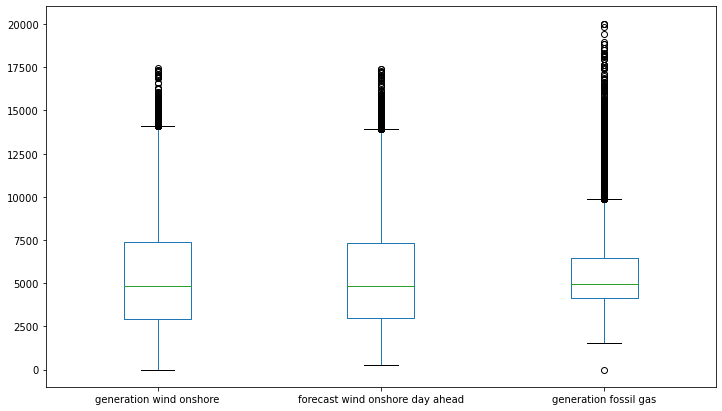

In [21]:
df_raw_energy[['generation wind onshore','forecast wind onshore day ahead','generation fossil gas']].plot.box(figsize=(12,7))

From looking at the boxplots, it is not clear that there are any outliers for the wind variables, or for the maximum for the gas. However, a generation of '0' for the gas does seem to be an outlier and so this should be cleaned.

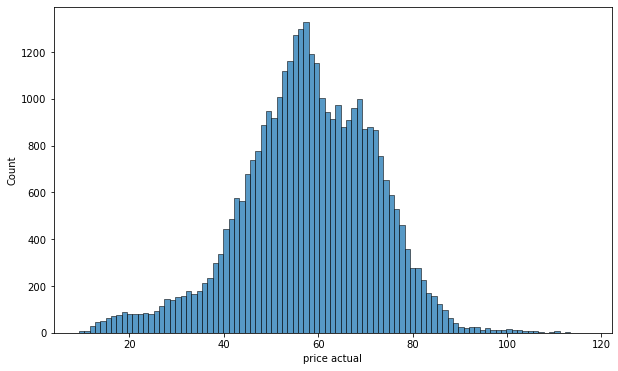

In [22]:
# Hist graph to show distribution of target variable
plt.figure(figsize=(10,6))
sns.histplot(df_raw_energy,x='price actual');

### Prepare Energy Dataset

In [12]:
# Drop columns containing excessive (>90%) NULLs
df_energy = df_raw_energy.drop(['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'], axis=1, inplace=False)

# Drop columns containing excessive (>90%) zeros
df_energy = df_energy.drop(['generation fossil coal-derived gas',
                                    'generation fossil oil shale',
                                    'generation fossil peat',
                                    'generation geothermal',
                                    'generation marine',
                                    'generation wind offshore'], axis=1, inplace=False)

# Rename columns by replacing all - or blank space with _
df_energy.columns = df_energy.columns.str.replace(' ','_').str.replace('-','_')                   

In [13]:
# Interpolate Outliers
df_energy.loc[df_energy['generation_fossil_gas'] == 0, 'generation_fossil_gas'] = np.nan
df_energy.interpolate(method='ffill', inplace=True, axis=0)

### Energy Dataset Feature Engineering

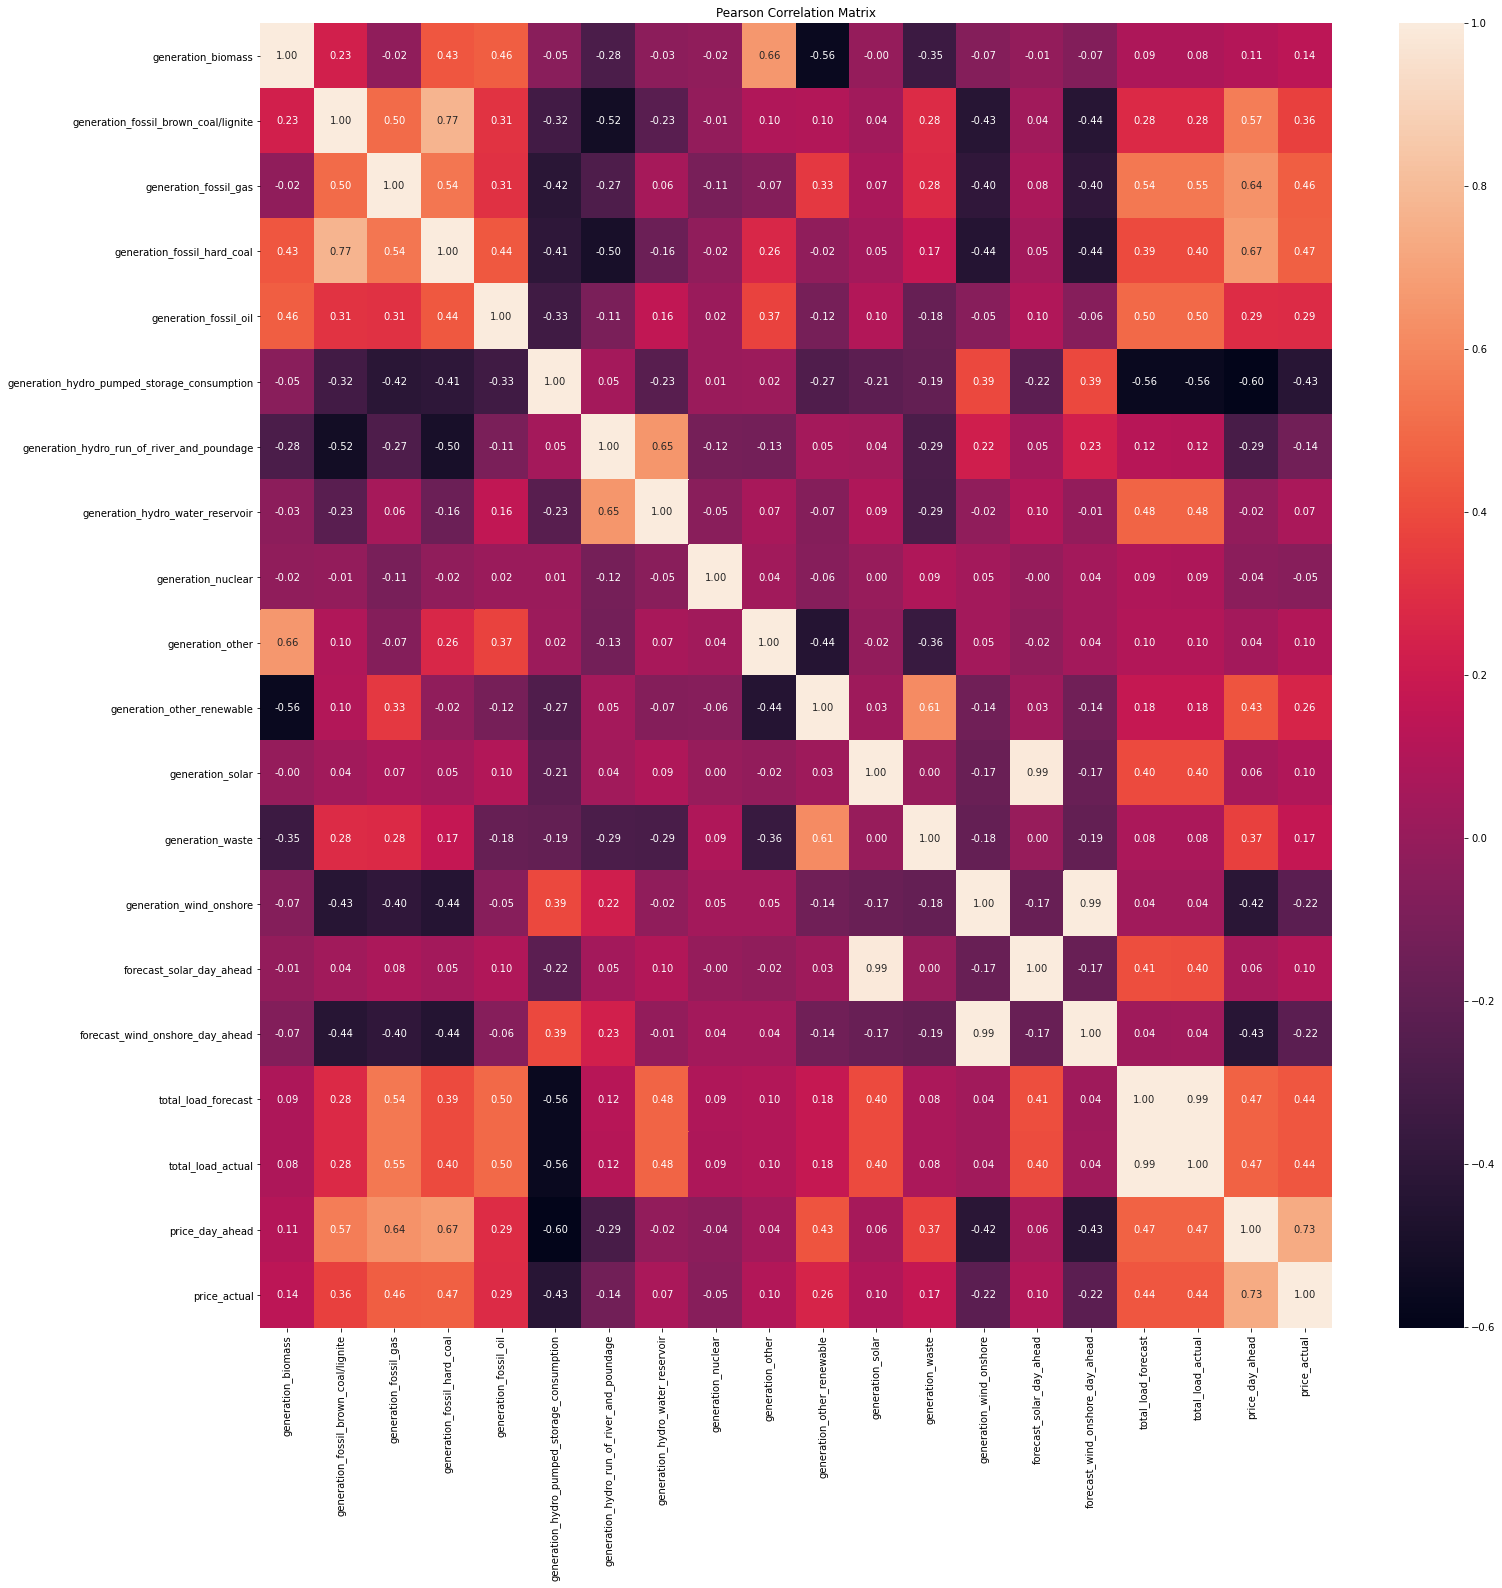

In [25]:
# Display Correlations amoung energy variables
correlations = df_energy.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

There are some pretty high correlations between some types of generation and so to reduce the number of variables, we will combine some of these, especially where we can see from the descriptive statistics that generate only small amounts.

In [14]:
# Create a new coal column to replace the two highly correlated coal generation columns
df_energy['generation_fossil_coal'] = df_energy[['generation_fossil_brown_coal/lignite',
                                                 'generation_fossil_hard_coal']].sum(axis=1)
df_energy = df_energy.drop(['generation_fossil_brown_coal/lignite', 'generation_fossil_hard_coal'], axis=1, inplace=False)
df_energy = df_energy.drop(['forecast_solar_day_ahead', 'forecast_wind_onshore_day_ahead', 'total_load_forecast','price_day_ahead'], axis=1, inplace=False)

display(df_energy.head(1))

,time,generation_biomass,generation_fossil_gas,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,total_load_actual,price_actual,generation_fossil_coal
0,2014-12-31 23:00:00+00:00,447.0,4844.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,65.41,5150.0


In [15]:
# Create some time related features
df_energy['month'] = df_energy['time'].dt.month
df_energy['hour'] = df_energy['time'].dt.hour
#df_energy['weekday'] = df_energy['time'].dt.weekday()
display(df_energy.head(1))

,time,generation_biomass,generation_fossil_gas,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,total_load_actual,price_actual,generation_fossil_coal,month,hour
0,2014-12-31 23:00:00+00:00,447.0,4844.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,65.41,5150.0,12,23


In [16]:
df_energy = df_energy.set_index('time')

### Join Two Datasets

In [17]:
# Join weather data with energy data
df_full = pd.merge(df_energy,df_weather_split,on="time")

display(df_full.head(1))

,generation_biomass,generation_fossil_gas,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,generation_other_renewable,generation_solar,...,wind_deg_Barcelona,rain_1h_Barcelona,clouds_all_Barcelona,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville,mean_temp
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,4844.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,...,58,0.0,0,1039.0,75,1.0,21,0.0,0,272.491463


In [18]:
df_reduced = df_full

## Pre-Processing

In [19]:
X_df = df_reduced[df_reduced.columns.drop('price_actual')]
X_columns = X_df.columns
X = X_df.values
y = df_reduced['price_actual'].values
y = y.reshape(-1, 1)

In [20]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_X.fit(X)
scaler_y.fit(y)
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

## Feature Selection

In [21]:
# Apply SelectKBest class to extract top 20 best features using the ANOVA f-test
bestfeatures = SelectKBest(k=20)
fit = bestfeatures.fit(X_norm,y_norm)

# Extract the scores and show as a table
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(20,'Score'))

C:\Users\rebecca.knight\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


                                          Specs     Score
3   generation_hydro_pumped_storage_consumption  2.743401
1                         generation_fossil_gas  2.649892
13                       generation_fossil_coal  2.469173
12                            total_load_actual  2.255598
14                                        month  1.697878
24                            wind_speed_Madrid  1.641938
18                          wind_speed_Valencia  1.509094
2                         generation_fossil_oil  1.497012
34                           pressure_Barcelona  1.460949
30                            wind_speed_Bilbao  1.455592
11                      generation_wind_onshore  1.416669
8                    generation_other_renewable  1.399450
5              generation_hydro_water_reservoir  1.373283
36                         wind_speed_Barcelona  1.301086
15                                         hour  1.292252
10                             generation_waste  1.252761
4    generatio

In [22]:
no_features = 5
X_selected_columns = featureScores.nlargest(no_features,'Score')['Specs'].values
X_selected_df = df_reduced[X_selected_columns]
X_selected = X_selected_df.values
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_X.fit(X_selected)
X_norm = scaler_X.transform(X_selected)

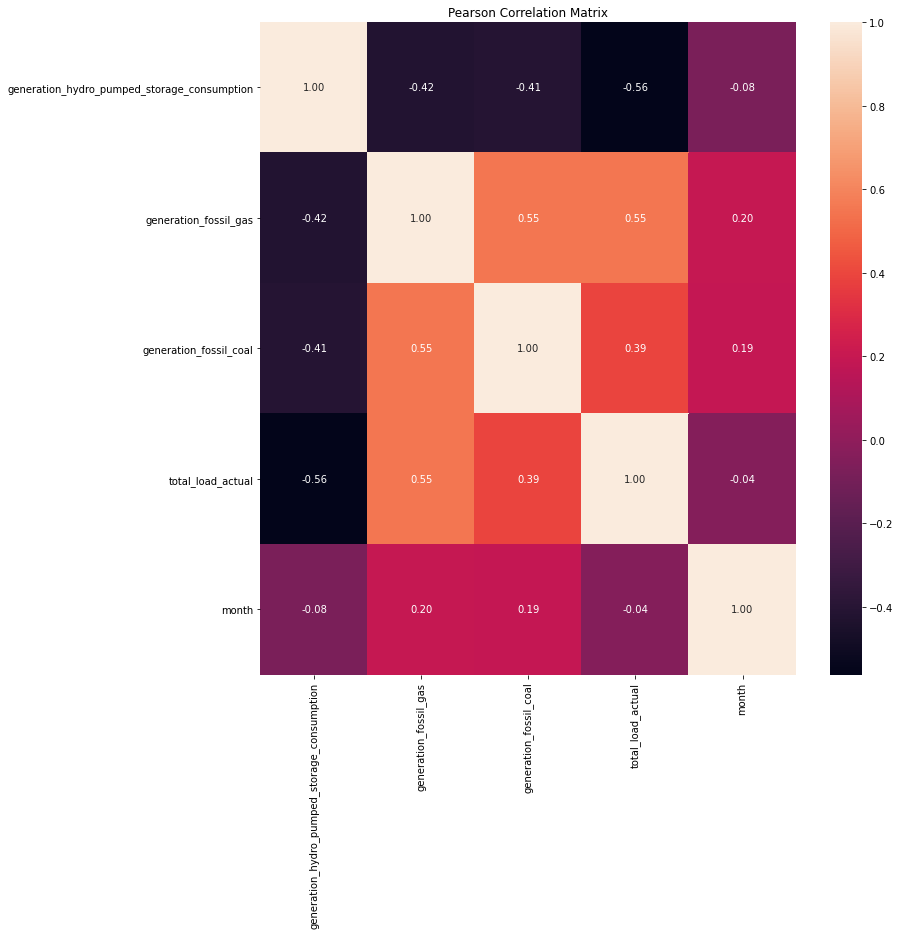

In [35]:
# Display Correlations amoung energy variables
correlations = X_selected_df.corr(method='pearson')
fig = plt.figure(figsize=(12, 12))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

The above correlation matrix does show some collinearity but at least no values that have very high correlations.

## Pre-Processing - Continued

In [23]:
def seq_data_manipulator(data, seq_dim, input_dim, output_dim):
    X,Y=data
    X=np.array(X)
    Y=np.array(Y)

    lx=len(X)
    x = [] 
    y = []

    for i in range(seq_dim,lx):
        x.append(X[i-seq_dim:i, 0:(input_dim)])# append adds elements to the end of the list. i-60:i takes the values from i-seq_dim to i
        y.append(Y[i, 0:output_dim])

    x, y= np.array(x), np.array(y)
    return (x, y)

In [24]:
seq_dim=24
input_dim = no_features
output_dim = 1
x,y=seq_data_manipulator((X_norm, y_norm), seq_dim, input_dim, output_dim)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42, shuffle=True)
print(x.shape)
print(y.shape)

(35040, 24, 5)
(35040, 1)


## Recurrent Neural Network

In [25]:
def performance(prediction, y_test, title):
    
    print('Performance for: ',title)
    
    prediction_unscaled = scaler_y.inverse_transform(prediction)
    y_test_unscaled = scaler_y.inverse_transform(y_test)
    
    error = prediction_unscaled-y_test_unscaled
    error_squared = error**2
    error_meansq = np.mean(error_squared, axis=0)
    print('mean squared error (unscaled):',error_meansq)

    return None

def performance_long(prediction, y_test, title):
    
    print('Performance for: ',title)
    
    error = prediction-y_test
    error_squared = error**2
    error_meansq = np.mean(error_squared, axis=0)
    print('mean squared error (scaled):',error_meansq)
    
    prediction_unscaled = scaler_y.inverse_transform(prediction)
    y_test_unscaled = scaler_y.inverse_transform(y_test)
    
    error = prediction_unscaled-y_test_unscaled
    error_squared = error**2
    error_meansq = np.mean(error_squared, axis=0)
    print('mean squared error (unscaled):',error_meansq)
    
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.plot(prediction_unscaled, y_test_unscaled,'o')#, color='black')
    plt.title(title)
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.xlim([0, 100])
    plt.ylim([0, 100])

    fig, ax = plt.subplots(figsize=(6, 4))
    plt.title(title)
    plt.xlabel("Residual Error")
    plt.ylabel("Frequency")
    plt.hist(error, bins=20)

    plt.show()

    return None

In [27]:
#Neural Network Hyperparameters

num_epochs = 100
learning_rate = 0.001
batch_size =32#int(opt)32
dropout=0.05
hidden_dim_1=128# 32,64,128,512,1024
hidden_dim_2=256# 32,64,128,512,1024
output_activation = 'linear'
initial_activation = 'relu'
kernel_initializer="glorot_uniform"
bias_initializer="glorot_uniform"
loss_function='mae'
optimiser=optimizers.Adamax(lr=learning_rate)
metric=tf.keras.metrics.Accuracy
kernel_regularizer='l1'# 'l2','l1_l2'
recurrent_initializer="orthogonal"
recurrent_activation="tanh"

C:\Users\rebecca.knight\Anaconda3\lib\site-packages\keras\optimizer_v2\adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [28]:
history_RNN = History()
model_RNN = Sequential()
model_RNN.add(SimpleRNN(hidden_dim_1, input_shape=(seq_dim,input_dim), activation=initial_activation, use_bias=False, bias_initializer=bias_initializer,recurrent_initializer=recurrent_initializer,  recurrent_dropout=dropout,kernel_initializer=kernel_initializer, return_sequences = False))#,kernel_regularizer=kernel_regularizer))

history_LSTM = History()
model_LSTM = Sequential()
model_LSTM.add(LSTM(hidden_dim_1, input_shape=(seq_dim,input_dim), activation=initial_activation, use_bias=False, bias_initializer=bias_initializer, recurrent_activation=recurrent_activation,recurrent_initializer=recurrent_initializer,  recurrent_dropout=dropout,kernel_initializer=kernel_initializer, return_sequences = False))#,kernel_regularizer=kernel_regularizer))

hidden_dim_1 = 128
history_GRU = History()
model_GRU = Sequential()
model_GRU.add(GRU(hidden_dim_1, input_shape=(seq_dim,input_dim), activation=initial_activation, use_bias=False, bias_initializer=bias_initializer, recurrent_activation=recurrent_activation,recurrent_initializer=recurrent_initializer,  recurrent_dropout=dropout,kernel_initializer=kernel_initializer, return_sequences = False))#,kernel_regularizer=kernel_regularizer))

hidden_dim_1 = 48
hidden_dim_2 = 96
history_GRU_2 = History()
model_GRU_2 = Sequential()
model_GRU_2.add(GRU(hidden_dim_1, input_shape=(seq_dim,input_dim), activation=initial_activation, use_bias=False, bias_initializer=bias_initializer, recurrent_activation=recurrent_activation,recurrent_initializer=recurrent_initializer,  recurrent_dropout=dropout,kernel_initializer=kernel_initializer, return_sequences = True))#,kernel_regularizer=kernel_regularizer))
model_GRU_2.add(GRU(hidden_dim_2, input_shape=(seq_dim,hidden_dim_1), activation=initial_activation, use_bias=False, bias_initializer=bias_initializer, recurrent_activation=recurrent_activation,recurrent_initializer=recurrent_initializer,  recurrent_dropout=dropout,kernel_initializer=kernel_initializer, return_sequences = False))#,kernel_regularizer=kernel_regularizer))

hidden_dim_1 = 48
hidden_dim_2 = 64
hidden_dim_3 = 48
history_GRU_3 = History()
model_GRU_3 = Sequential()
model_GRU_3.add(GRU(hidden_dim_1, input_shape=(seq_dim,input_dim), activation=initial_activation, use_bias=False, bias_initializer=bias_initializer, recurrent_activation=recurrent_activation,recurrent_initializer=recurrent_initializer,  recurrent_dropout=dropout,kernel_initializer=kernel_initializer, return_sequences = True))#,kernel_regularizer=kernel_regularizer))
model_GRU_3.add(GRU(hidden_dim_2, input_shape=(seq_dim,hidden_dim_1), activation=initial_activation, use_bias=False, bias_initializer=bias_initializer, recurrent_activation=recurrent_activation,recurrent_initializer=recurrent_initializer,  recurrent_dropout=dropout,kernel_initializer=kernel_initializer, return_sequences = True))#,kernel_regularizer=kernel_regularizer))
model_GRU_3.add(GRU(hidden_dim_3, input_shape=(seq_dim,hidden_dim_2), activation=initial_activation, use_bias=False, bias_initializer=bias_initializer, recurrent_activation=recurrent_activation,recurrent_initializer=recurrent_initializer,  recurrent_dropout=dropout,kernel_initializer=kernel_initializer, return_sequences = False))#,kernel_regularizer=kernel_regularizer))

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=300)

model_RNN.add(Dense(units=output_dim, activation=output_activation))
model_RNN.compile(loss=loss_function,
              optimizer=optimiser)
print(model_RNN.summary())

model_LSTM.add(Dense(units=output_dim, activation=output_activation))
model_LSTM.compile(loss=loss_function,
              optimizer=optimiser)
print(model_LSTM.summary())

model_GRU.add(Dense(units=output_dim, activation=output_activation))
model_GRU.compile(loss=loss_function,
              optimizer=optimiser)
print(model_GRU.summary())

model_GRU_2.add(Dense(units=output_dim, activation=output_activation))
model_GRU_2.compile(loss=loss_function,
              optimizer=optimiser)
print(model_GRU_2.summary())

model_GRU_3.add(Dense(units=output_dim, activation=output_activation))
model_GRU_3.compile(loss=loss_function,
              optimizer=optimiser)
print(model_GRU_3.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               17024     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 17,153
Trainable params: 17,153
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 68,225
Tr

In [61]:
model_RNN.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=[callback, history_RNN])#validation_split=0.2,

Epoch 1/100
822/822 [==============================] - 10s 11ms/step - loss: 0.0892
Epoch 2/100
822/822 [==============================] - 9s 11ms/step - loss: 0.0798
Epoch 3/100
822/822 [==============================] - 8s 10ms/step - loss: 0.0767
Epoch 4/100
822/822 [==============================] - 9s 10ms/step - loss: 0.0749
Epoch 5/100
822/822 [==============================] - 9s 12ms/step - loss: 0.0736
Epoch 6/100
822/822 [==============================] - 9s 11ms/step - loss: 0.0726
Epoch 7/100
822/822 [==============================] - 9s 11ms/step - loss: 0.0714
Epoch 8/100
822/822 [==============================] - 9s 11ms/step - loss: 0.0709
Epoch 9/100
822/822 [==============================] - 9s 11ms/step - loss: 0.0706
Epoch 10/100
822/822 [==============================] - 9s 11ms/step - loss: 0.0699
Epoch 11/100
822/822 [==============================] - 9s 11ms/step - loss: 0.0694
Epoch 12/100
822/822 [==============================] - 11s 13ms/step - loss: 0.0687

In [62]:
model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=[callback, history_LSTM])#validation_split=0.2,

Epoch 1/100
822/822 [==============================] - 21s 23ms/step - loss: 0.1776
Epoch 2/100
822/822 [==============================] - 21s 26ms/step - loss: 0.0911
Epoch 3/100
822/822 [==============================] - 22s 27ms/step - loss: 0.0867
Epoch 4/100
822/822 [==============================] - 22s 27ms/step - loss: 0.0845
Epoch 5/100
822/822 [==============================] - 20s 24ms/step - loss: 0.0837
Epoch 6/100
822/822 [==============================] - 20s 25ms/step - loss: 0.0814
Epoch 7/100
822/822 [==============================] - 21s 25ms/step - loss: 0.0804
Epoch 8/100
822/822 [==============================] - 20s 24ms/step - loss: 0.0794
Epoch 9/100
822/822 [==============================] - 738s 898ms/step - loss: 0.0786
Epoch 10/100
822/822 [==============================] - 24s 30ms/step - loss: 0.0780
Epoch 11/100
822/822 [==============================] - 20s 25ms/step - loss: 0.0774
Epoch 12/100
822/822 [==============================] - 22s 27ms/step - 

822/822 [==============================] - 21s 25ms/step - loss: 0.0549
Epoch 98/100
822/822 [==============================] - 21s 25ms/step - loss: 0.0550
Epoch 99/100
822/822 [==============================] - 23s 27ms/step - loss: 0.0546
Epoch 100/100
822/822 [==============================] - 22s 26ms/step - loss: 0.0550


In [63]:
model_GRU.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=[callback, history_GRU])#validation_split=0.2,

Epoch 1/100
822/822 [==============================] - 18s 20ms/step - loss: 0.0908
Epoch 2/100
822/822 [==============================] - 18s 22ms/step - loss: 0.0777
Epoch 3/100
822/822 [==============================] - 18s 22ms/step - loss: 0.0762
Epoch 4/100
822/822 [==============================] - 17s 21ms/step - loss: 0.0749
Epoch 5/100
822/822 [==============================] - 18s 22ms/step - loss: 0.0737
Epoch 6/100
822/822 [==============================] - 18s 22ms/step - loss: 0.0726
Epoch 7/100
822/822 [==============================] - 18s 22ms/step - loss: 0.0716
Epoch 8/100
822/822 [==============================] - 16s 20ms/step - loss: 0.0706
Epoch 9/100
822/822 [==============================] - 18s 21ms/step - loss: 0.0700
Epoch 10/100
822/822 [==============================] - 17s 21ms/step - loss: 0.0692
Epoch 11/100
822/822 [==============================] - 17s 20ms/step - loss: 0.0687
Epoch 12/100
822/822 [==============================] - 16s 20ms/step - lo

In [30]:
model_GRU_2.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=[callback, history_GRU_2])#validation_split=0.2,

Epoch 1/100
822/822 [==============================] - 35s 35ms/step - loss: 0.0910
Epoch 2/100
822/822 [==============================] - 29s 35ms/step - loss: 0.0778
Epoch 3/100
822/822 [==============================] - 31s 37ms/step - loss: 0.0758
Epoch 4/100
822/822 [==============================] - 30s 36ms/step - loss: 0.0744
Epoch 5/100
822/822 [==============================] - 30s 36ms/step - loss: 0.0734
Epoch 6/100
822/822 [==============================] - 29s 36ms/step - loss: 0.0725
Epoch 7/100
822/822 [==============================] - 21s 26ms/step - loss: 0.0717
Epoch 8/100
822/822 [==============================] - 20s 24ms/step - loss: 0.0708
Epoch 9/100
822/822 [==============================] - 20s 25ms/step - loss: 0.0702
Epoch 10/100
822/822 [==============================] - 20s 25ms/step - loss: 0.0692
Epoch 11/100
822/822 [==============================] - 20s 25ms/step - loss: 0.0685
Epoch 12/100
822/822 [==============================] - 20s 25ms/step - lo

In [31]:
model_GRU_3.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=[callback, history_GRU_3])#validation_split=0.2,

Epoch 1/100
822/822 [==============================] - 32s 32ms/step - loss: 0.0943
Epoch 2/100
822/822 [==============================] - 27s 33ms/step - loss: 0.0776
Epoch 3/100
822/822 [==============================] - 27s 33ms/step - loss: 0.0758
Epoch 4/100
822/822 [==============================] - 27s 33ms/step - loss: 0.0748
Epoch 5/100
822/822 [==============================] - 27s 33ms/step - loss: 0.0737
Epoch 6/100
822/822 [==============================] - 27s 33ms/step - loss: 0.0728
Epoch 7/100
822/822 [==============================] - 26s 32ms/step - loss: 0.0719
Epoch 8/100
822/822 [==============================] - 27s 33ms/step - loss: 0.0711
Epoch 9/100
822/822 [==============================] - 28s 34ms/step - loss: 0.0702
Epoch 10/100
822/822 [==============================] - 28s 34ms/step - loss: 0.0695
Epoch 11/100
822/822 [==============================] - 28s 34ms/step - loss: 0.0686
Epoch 12/100
822/822 [==============================] - 28s 34ms/step - lo

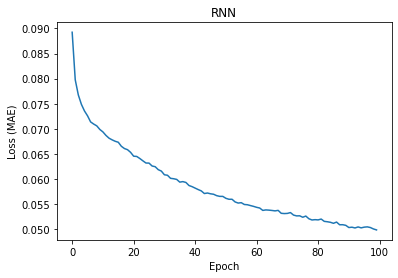

Performance for:  RNN
mean squared error (unscaled): [49.74939411]


In [71]:
plt.plot(history_RNN.history['loss'], label='train')
plt.title("RNN")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.show()

prediction_RNN=np.array(model_RNN.predict(X_test))

performance(prediction_RNN, y_test, "RNN")

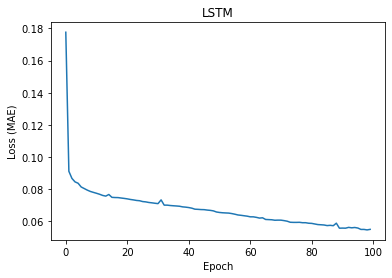

Performance for:  LTSM
mean squared error (unscaled): [72.37429182]


In [72]:
plt.plot(history_LSTM.history['loss'], label='train')
plt.title("LSTM")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.show()

prediction_LSTM=np.array(model_LSTM.predict(X_test))

performance(prediction_LSTM, y_test, "LTSM")

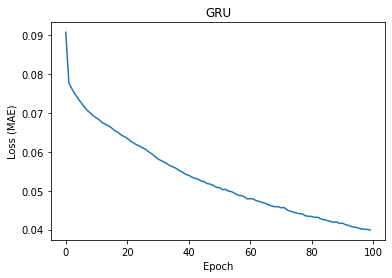

Performance for:  GRU
mean squared error (unscaled): [37.75083147]


In [73]:
plt.plot(history_GRU.history['loss'], label='train')
plt.title("GRU")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.show()

prediction_GRU=np.array(model_GRU.predict(X_test))

performance(prediction_GRU, y_test, "GRU")

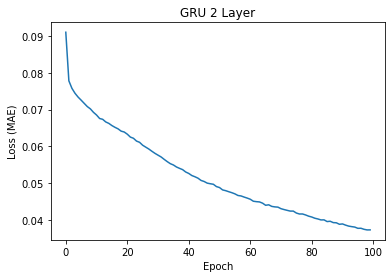

Performance for:  GRU 2 layer
mean squared error (unscaled): [33.36958036]


In [32]:
plt.plot(history_GRU_2.history['loss'], label='train')
plt.title("GRU 2 Layer")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.show()

prediction_GRU_2=np.array(model_GRU_2.predict(X_test))

performance(prediction_GRU_2, y_test, "GRU 2 layer")

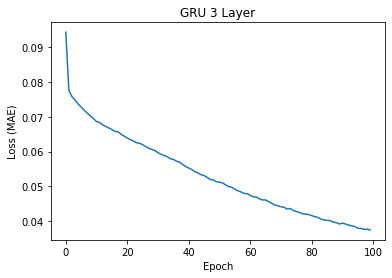

Performance for:  GRU 3 layer
mean squared error (unscaled): [33.20604339]


In [33]:
plt.plot(history_GRU_3.history['loss'], label='train')
plt.title("GRU 3 Layer")
plt.xlabel("Epoch")
plt.ylabel("Loss (MAE)")
plt.show()

prediction_GRU_3=np.array(model_GRU_3.predict(X_test))

performance(prediction_GRU_3, y_test, "GRU 3 layer")

Performance for:  RNN
mean squared error (scaled): [0.00430738]
mean squared error (unscaled): [49.74939411]


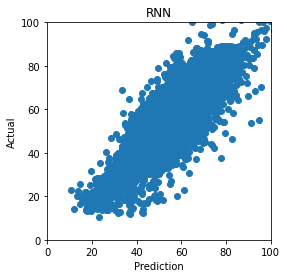

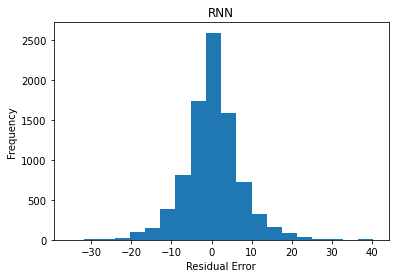

Performance for:  LTSM
mean squared error (scaled): [0.00626628]
mean squared error (unscaled): [72.37429182]


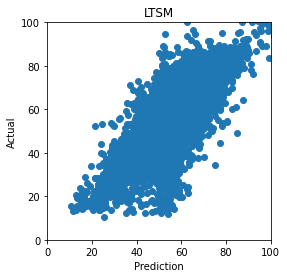

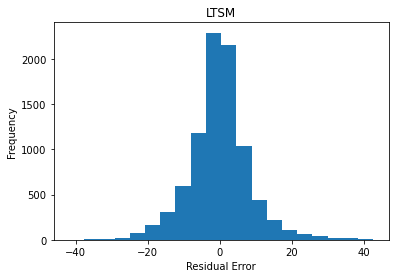

Performance for:  GRU
mean squared error (scaled): [0.00326853]
mean squared error (unscaled): [37.75083147]


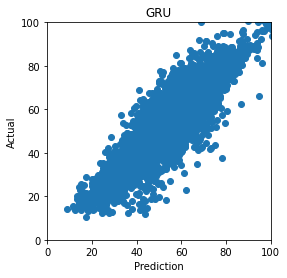

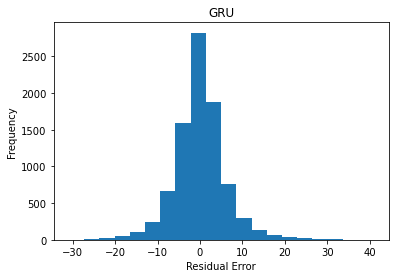

In [70]:
performance_long(prediction_RNN, y_test, "RNN")
performance_long(prediction_LSTM, y_test, "LTSM")
performance_long(prediction_GRU, y_test, "GRU")

Performance for:  GRU 2 layer
mean squared error (scaled): [0.00288919]
mean squared error (unscaled): [33.36958036]


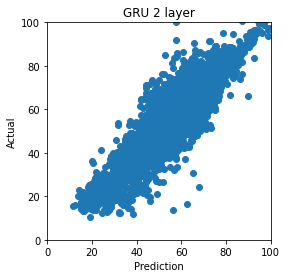

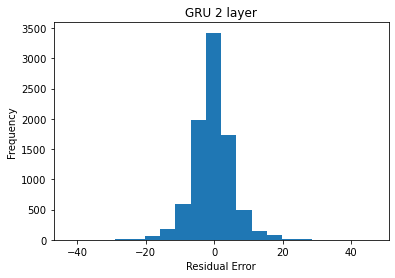

Performance for:  GRU 3 layer
mean squared error (scaled): [0.00287503]
mean squared error (unscaled): [33.20604339]


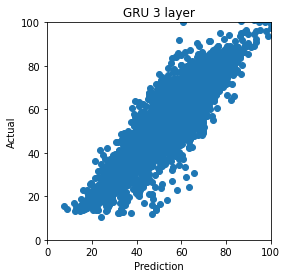

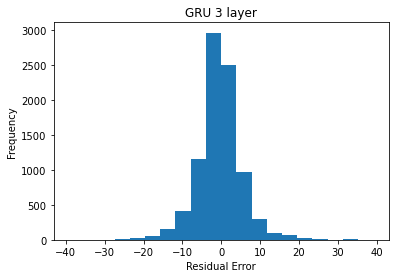

In [34]:
performance_long(prediction_GRU_2, y_test, "GRU 2 layer")
performance_long(prediction_GRU_3, y_test, "GRU 3 layer")

In [75]:
print(r2_score(prediction_RNN, y_test))
print(r2_score(prediction_GRU, y_test))
print(r2_score(prediction_LSTM, y_test))

0.6742252253258672
0.7773305849961384
0.47156411974343915


In [35]:
print(r2_score(prediction_GRU_2, y_test))
print(r2_score(prediction_GRU_3, y_test))

0.7803480362064886
0.7899494713939628
